Our approach for identifying poor-quality AI-generated exam items is by looking at the proportion of other (non-GPT4) models that selected the GPT4-selected "correct" answer. If the majority of a strong group of LLMs choose an answer other than the one that GPT-4 deems to be the "correct" answer, then that is evidence towards the GPT4-selected answer choice being "incorrect". Similarly, if there is no clear consensus among other LLM responses with respect to what the right answer choice should be, that is evidence that the GPT4-generated item may have flaws.

### Package Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, roc_auc_score

### Copy the data from Carina

Data are located on Carina `/share/pi/nigam/scottyf/ai_generated_questions.csv` and are generated by calling `inference_single_model.sh`

In [2]:
# Located on Carina at /share/pi/nigam/scottyf/ai_generated_questions.csv
ai_generated_questions = pd.read_csv("~/Downloads/ai_generated_questions.csv")
ai_generated_output = pd.read_csv("~/Downloads/ai_generated_questions_output.csv")
ai_generated_output['model'].unique()

array(['Qwen1.5-72B-Chat', 'Mixtral-8x7B-Instruct-v0.1',
       'Mistral-7B-Instruct-v0.2', 'Mistral-7B-Instruct-v0.1',
       'zephyr-7b-beta', 'llama-2-7b-chat_huggingface',
       'llama-2-13b-chat_huggingface', 'AlpaCare-llama2-7b',
       'AlpaCare-llama2-13b'], dtype=object)

### Filter down to just the best-performing models

In [3]:
human_generated_questions = ai_generated_output.loc[ai_generated_output["item_num"].str.endswith("H"), :].copy()
human_generated_questions["model_is_correct"] = human_generated_questions["model_answer"] == human_generated_questions["gt_answer"]
model_perf_df = (
    human_generated_questions
    .groupby("model")
    .agg(pct_correct = ("model_is_correct", "mean"))
    .reset_index()
    .sort_values("pct_correct", ascending=False)
)
model_perf_df

,model,pct_correct
5,Qwen1.5-72B-Chat,0.78
4,Mixtral-8x7B-Instruct-v0.1,0.72
3,Mistral-7B-Instruct-v0.2,0.56
8,zephyr-7b-beta,0.54
0,AlpaCare-llama2-13b,0.50
2,Mistral-7B-Instruct-v0.1,0.46
1,AlpaCare-llama2-7b,0.38
6,llama-2-13b-chat_huggingface,0.38
7,llama-2-7b-chat_huggingface,0.34


In [4]:
ai_generated_output = ai_generated_output[
    ai_generated_output['model'].isin([
        'Qwen1.5-72B-Chat', 
        'Mixtral-8x7B-Instruct-v0.1', 
        'Mistral-7B-Instruct-v0.2', 
        'zephyr-7b-beta'
    ])
]

### Define what is a "good" vs. "bad" AI-generated question using clinician labels

We had 2 clinicians review each AI-generated question and decide whether it was a "good" question or a "bad" question. Often there was consensus, but sometimes it was 50/50. For this analysis, we take the view that if *any* clinician deemed that an AI-generated question was "bad" then it was indeed "bad".

In [6]:
is_good_qa = ai_generated_questions[['ItemNum', 'true_human_or_GPT4', 'ItemText_Raw']].copy()
is_good_qa['is_bad_strict'] = ai_generated_questions['consensus_is_gpt_qa_correct'] == 'no'
is_good_qa['is_bad_relaxed'] = ai_generated_questions['consensus_is_gpt_qa_correct'].isin(['no', '50/50'])
is_good_qa['consensus_reason'] = ai_generated_questions['consensus_reason']
is_good_qa.tail()

,ItemNum,true_human_or_GPT4,ItemText_Raw,is_bad_strict,is_bad_relaxed,consensus_reason
95,059G,GPT,A 27-year-old woman visits her primary care ph...,False,True,Multiple correct answers
96,110H,human,A 45-year-old man is brought to the emergency ...,False,False,NaN
97,065H,human,A 2-week-old boy is evaluated in the neonatal ...,False,False,NaN
98,028G,GPT,A 35-year-old woman presents to the emergency ...,False,True,AI-chosen answer is incorrect
99,091G,GPT,A 65-year-old man presents to the primary care...,True,True,Multiple correct answers


### Calculate proportion of models that selected each answer choice

In [29]:
ai_questions_answer_probabilities_df = ai_generated_output.groupby('item_num').agg(
    prop_A = ('model_answer', lambda x: (x == 'A').mean()),
    prop_B = ('model_answer', lambda x: (x == 'B').mean()),
    prop_C = ('model_answer', lambda x: (x == 'C').mean()),
    prop_D = ('model_answer', lambda x: (x == 'D').mean()),
    prop_E = ('model_answer', lambda x: (x == 'E').mean()),
    prop_F = ('model_answer', lambda x: (x == 'F').mean()),
    prop_G = ('model_answer', lambda x: (x == 'G').mean()),
    prop_H = ('model_answer', lambda x: (x == 'H').mean()),
    correct_answer = ('gt_answer', 'first')
)
ai_questions_answer_probabilities_df = (
    ai_questions_answer_probabilities_df
    .reset_index()
    .merge(is_good_qa, left_on='item_num', right_on='ItemNum')
)
ai_questions_answer_probabilities_df.head()

,item_num,prop_A,prop_B,prop_C,prop_D,prop_E,prop_F,prop_G,prop_H,correct_answer,ItemNum,true_human_or_GPT4,ItemText_Raw,is_bad_strict,is_bad_relaxed,consensus_reason
0,006G,0.0,0.50,0.0,0.00,0.5,0.0,0.0,0.0,B,006G,GPT,A 36-year-old man presents to the emergency de...,True,True,Multiple correct answers
1,006H,1.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,A,006H,human,A previously healthy 29-year-old woman is admi...,False,False,NaN
2,007G,0.0,0.25,0.0,0.75,0.0,0.0,0.0,0.0,D,007G,GPT,"A 32-year-old gravida 2, para 1 woman presents...",False,False,NaN
3,007H,0.0,0.75,0.0,0.25,0.0,0.0,0.0,0.0,D,007H,human,A 27-year-old primigravid woman comes to the p...,False,False,NaN
4,009G,0.0,0.75,0.0,0.25,0.0,0.0,0.0,0.0,B,009G,GPT,A 45-year-old woman presents to the emergency ...,False,False,NaN


### Calculate proportion of LLMs that selected the GPT4-selected "Answer"

In [8]:
ai_questions_llm_response_probs_df = []

for i, row in ai_questions_answer_probabilities_df.iterrows():
    if row['true_human_or_GPT4'] == 'human':
        continue
    majority_vote = None
    max_vote = -np.inf
    for answer_choice in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        if row[f'prop_{answer_choice}'] > max_vote:
            majority_vote = answer_choice
            max_vote = row[f'prop_{answer_choice}']
    the_correct_answer = row['correct_answer']
    new_row = {
        'ItemNum': row['ItemNum'],
        'ItemText_Raw': row['ItemText_Raw'],
        'majority_vote': majority_vote,
        'prop_llms_in_majority': max_vote,
        'correct_answer': the_correct_answer,
        'prop_llms_correct': row[f'prop_{the_correct_answer}'],
        'true_human_or_GPT4': row['true_human_or_GPT4'],
        'is_bad_strict': row['is_bad_strict'],
        'is_bad_relaxed': row['is_bad_relaxed'],
        'consensus_reason': row['consensus_reason']
    }
    ai_questions_llm_response_probs_df.append(new_row)

ai_questions_llm_response_probs_df = pd.DataFrame(ai_questions_llm_response_probs_df).sort_values('prop_llms_correct')
ai_questions_llm_response_probs_df.head()

,ItemNum,ItemText_Raw,majority_vote,prop_llms_in_majority,correct_answer,prop_llms_correct,true_human_or_GPT4,is_bad_strict,is_bad_relaxed,consensus_reason
46,111G,A 27-year-old woman presents to the clinic wit...,D,0.75,A,0.00,GPT,False,True,No correct answer
29,075G,A 12-year-old boy is brought to the pediatrici...,D,1.00,C,0.00,GPT,False,False,NaN
26,068G,A 45-year-old man presents to the clinic with ...,B,0.75,C,0.00,GPT,True,True,Multiple correct answers
15,043G,A 62-year-old woman presents to the clinic wit...,C,1.00,A,0.00,GPT,False,True,AI-chosen answer is incorrect
22,063G,"A 28-year-old woman, gravida 3, para 3, presen...",D,0.50,E,0.25,GPT,True,True,AI-chosen answer is incorrect


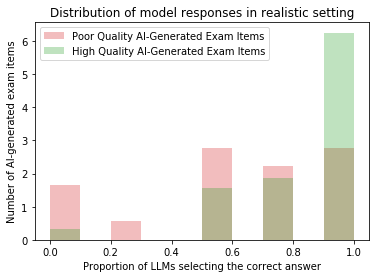

In [10]:
bins = np.linspace(0, 1, 11)
plt.hist(
    ai_questions_llm_response_probs_df.loc[ai_questions_llm_response_probs_df['is_bad_relaxed'] == 1, 'prop_llms_correct'],
    bins=bins,
    color='tab:red',
    alpha=0.3,
    label='Poor Quality AI-Generated Exam Items',
    density=True
)
plt.hist(
    ai_questions_llm_response_probs_df.loc[ai_questions_llm_response_probs_df['is_bad_relaxed'] == 0, 'prop_llms_correct'],
    bins=bins,
    color='tab:green',
    alpha=0.3,
    label='High Quality AI-Generated Exam Items',
    density=True
)
plt.title('Distribution of model responses in realistic setting')
plt.xlabel('Proportion of LLMs selecting the correct answer')
plt.ylabel('Number of AI-generated exam items')
plt.legend()
plt.show()

### Classify AI-generated as good vs. bad based on proportion of LLMs that selected GPT4-chosen answer

In [24]:
print("Ability of LLM ensemble to detect poor quality AI-generated questions in realistic setting")
for thresh in np.linspace(0.01, 1, 11):
    y_true = ai_questions_llm_response_probs_df['is_bad_relaxed']  # Whether the answer choice was incorrect
    # y_pred = ai_questions_llm_response_probs_df['prop_llms_in_majority'] < thresh
    y_pred = (1-ai_questions_llm_response_probs_df['prop_llms_correct']) > thresh
    # y_pred = np.logical_and(
    #     ai_questions_llm_response_probs_df['prop_llms_in_majority'] < thresh, 
    #     ai_questions_llm_response_probs_df['prop_llms_correct'] < thresh, 
    # )
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    print(f"threshold={thresh:.2f}, precision={precision:.2f}, recall={recall:.2f}")

auroc = roc_auc_score(
    ai_questions_llm_response_probs_df['is_bad_relaxed'], 
    1-ai_questions_llm_response_probs_df['prop_llms_correct']
)
print(f"AUROC = {auroc}")

Ability of LLM ensemble to detect poor quality AI-generated questions in realistic setting
threshold=0.01, precision=0.52, recall=0.72
threshold=0.11, precision=0.52, recall=0.72
threshold=0.21, precision=0.52, recall=0.72
threshold=0.31, precision=0.60, recall=0.50
threshold=0.41, precision=0.60, recall=0.50
threshold=0.51, precision=0.80, recall=0.22
threshold=0.60, precision=0.80, recall=0.22
threshold=0.70, precision=0.80, recall=0.22
threshold=0.80, precision=0.75, recall=0.17
threshold=0.90, precision=0.75, recall=0.17
threshold=1.00, precision=0.00, recall=0.00
AUROC = 0.7118055555555556


/Users/scottyf/anaconda3/envs/youper/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
